# Generation

In [1]:
from pard.parallel.utils import find_checkpoint_with_lowest_val_loss
from pard.parallel.task import AutoregressiveDiffusion, PredictBlockProperties

device = 0

blocksize_model_dir = 'checkpoints/block_prediction/qm9.3hops.ppgnTrans-Parallel.BlockID11.bn.PreNorm=1.H256.E64.L8-lr0.0004.cosine'
diffusion_model_dir = 'checkpoints/local_denoising/qm9.3hops.ppgnTrans-Parallel.BlockID11.bn.PreNorm=1.H256.E64.L8-lr0.0004.cosine-ires1.blocktime0.uni_noise1.T20.cosine.vlb1.ce0.1.combine=False'
blocksize_path = find_checkpoint_with_lowest_val_loss(blocksize_model_dir)
diffusion_path = find_checkpoint_with_lowest_val_loss(diffusion_model_dir)

blocksize_model = PredictBlockProperties.load_from_checkpoint(blocksize_path, map_location=f'cuda:{device}')
diffusion_model = AutoregressiveDiffusion.load_from_checkpoint(diffusion_path, combine_training=False, map_location=f'cuda:{device}')
diffusion_model.blocksize_model = blocksize_model

node_noise: tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]), torch.Size([6])
edge_noise: tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]), torch.Size([5])


In [2]:
from pard.utils import check_block_id_train_vs_generation
generated_batch = diffusion_model.generate(100).to('cpu') 
generated_list = check_block_id_train_vs_generation(generated_batch.nodes, generated_batch.edges, generated_batch.nodes_blockid, train_max_hops=3)

In [7]:
l = []
l.extend(generated_list)
m = 100*sum(l) / len(l)
print('test',m)

test 95.0


In [10]:
import logging
print('Percentage of graphs that have the same generation block path as training block path:',
                100*sum(l) / len(l))

Percentage of graphs that have the same generation block path as training block path: 95.0


In [6]:
import os, re
def find_checkpoint_with_lowest_val_loss(directory):
    lowest_val_loss = float('inf')
    best_checkpoint = None
    # Regex to match the pattern in the filename and extract the loss value
    pattern = re.compile(r'epoch=([\d.]+)+-val_loss=([\d.]+)\.ckpt')

    for filename in os.listdir(directory):
        match = pattern.search(filename)
        # print(match.group(0))
        if match:
            print(match.group(0), match.group(1))
            val_loss = float(match.group(1))
            # epoch = float(match.group(0))
find_checkpoint_with_lowest_val_loss(diffusion_model_dir)

epoch=85-val_loss=2.042.ckpt 2.042
epoch=99-val_loss=2.049.ckpt 2.049
epoch=94-val_loss=2.048.ckpt 2.048
epoch=83-val_loss=2.047.ckpt 2.047
epoch=91-val_loss=2.046.ckpt 2.046


# Stats

In [3]:
from pard.dataset import DATA_INFO
dataset = 'grid'
data_info_dict = DATA_INFO[dataset]
atom_decoder = data_info_dict.get('atom_decoder', None)
metric_class = data_info_dict.get('metric_class', None)
original_datasets = {split:data_info_dict['class'](**(data_info_dict['default_args'] | {'split':split})) for split in ['train', 'val', 'test']}

print( sum(len(dataset) for dataset in original_datasets.values()))
print('num_nodes avg:', sum(sum([x.num_nodes for x in original_datasets[split]])  for split in ['train', 'val', 'test']) ) 
print('num_edges avg:', sum(sum([x.num_edges for x in original_datasets[split]]) for split in ['train', 'val', 'test']) )

100
num_nodes avg: 21025
num_edges avg: 78300


# Visualization

### QM9

In [29]:
# load model and generate 
from pard.utils import find_checkpoint_with_lowest_val_loss
from pard.parallel.task import AutoregressiveDiffusion, PredictBlockProperties

device = 5

blocksize_model_dir = 'checkpoints/block_prediction/qm9.3hops.ppgnTrans-Parallel.BlockID11.bn.PreNorm=1.H256.E64.L8-lr0.0004.cosine'
diffusion_model_dir = 'checkpoints/local_denoising/qm9.3hops.ppgnTrans-Parallel.BlockID11.bn.PreNorm=1.H256.E64.L8-lr0.0004.cosine-ires1.blocktime0.uni_noise1.T70.cosine.vlb1.ce0.1.combine=False'
blocksize_path = find_checkpoint_with_lowest_val_loss(blocksize_model_dir)
diffusion_path = find_checkpoint_with_lowest_val_loss(diffusion_model_dir)

blocksize_model = PredictBlockProperties.load_from_checkpoint(blocksize_path, map_location=f'cuda:{device}')
diffusion_model = AutoregressiveDiffusion.load_from_checkpoint(diffusion_path, combine_training=False, map_location=f'cuda:{device}')
diffusion_model.blocksize_model = blocksize_model

generated_batch = diffusion_model.generate(25).to('cpu') 

node_noise: tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]), torch.Size([6])
edge_noise: tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]), torch.Size([5])


<module 'matplotlib.pyplot' from '/home/lingxiao/.conda/envs/pt2/lib/python3.10/site-packages/matplotlib/pyplot.py'>

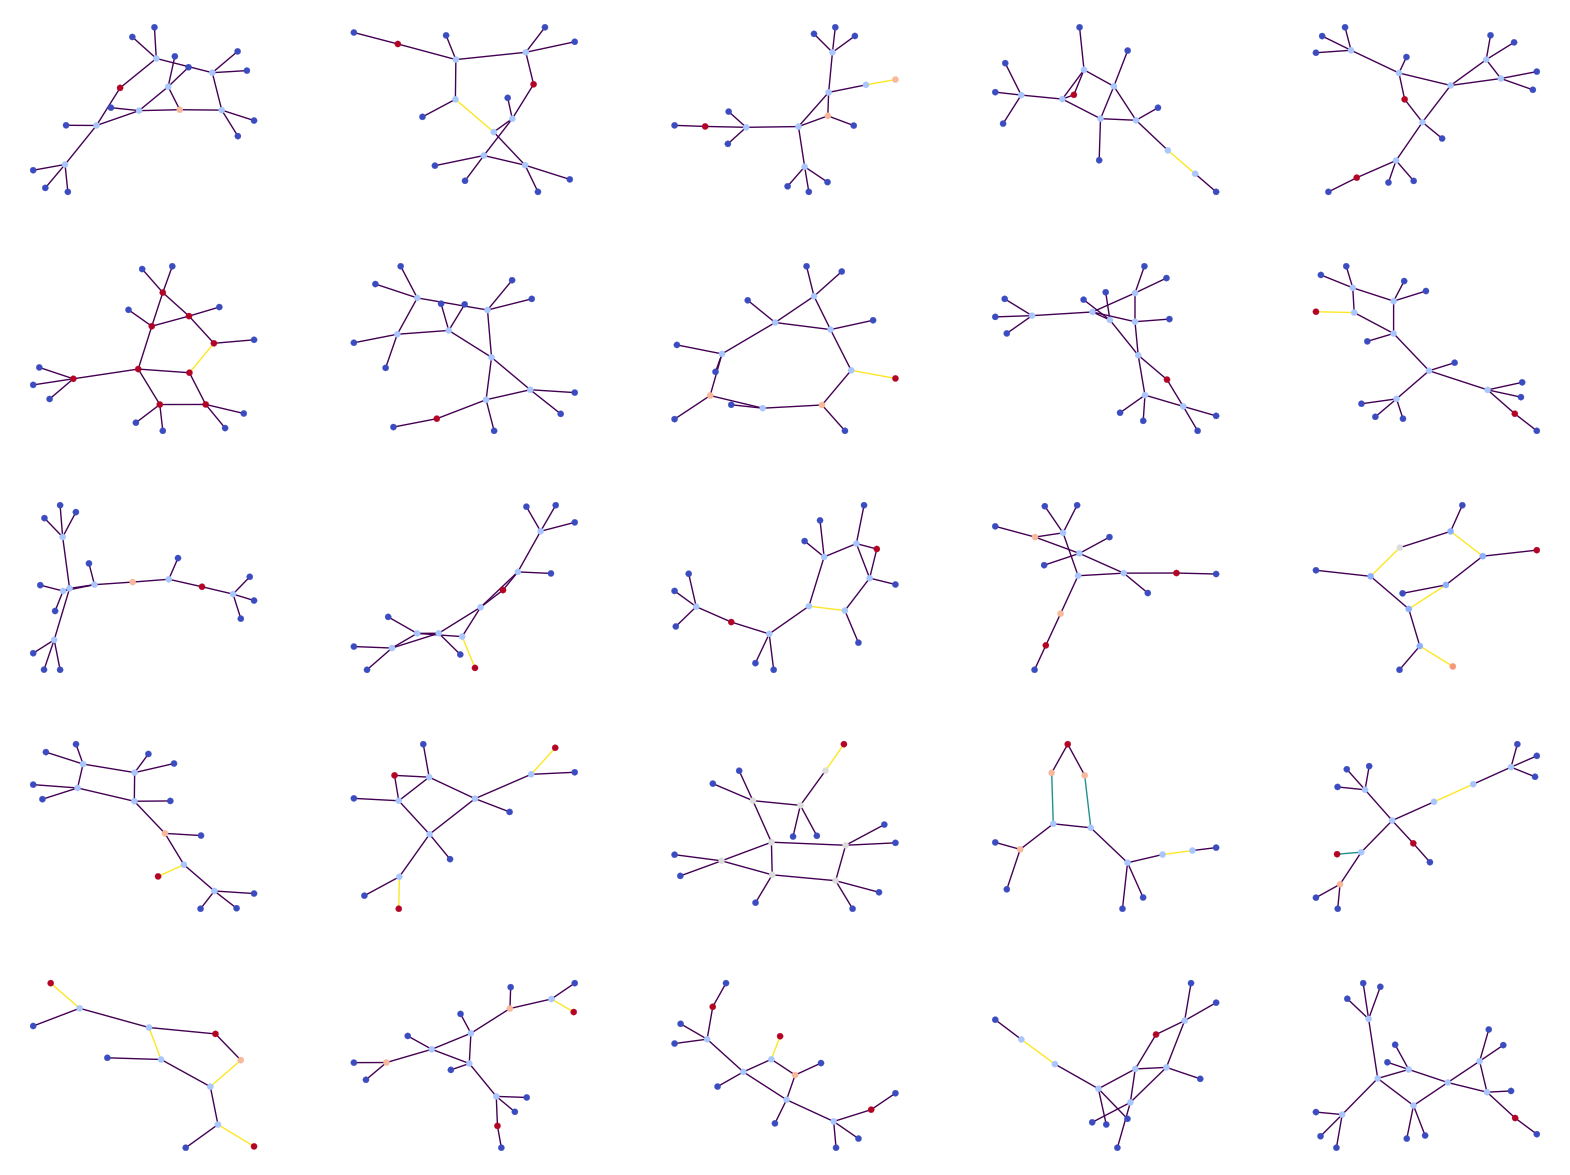

In [30]:
from pard.utils import from_batch_onehot_to_pyg_list, plot_pgy_graphs 
generated_list = from_batch_onehot_to_pyg_list(generated_batch.nodes, generated_batch.edges)
plot_pgy_graphs(generated_list)


### Grid

<module 'matplotlib.pyplot' from '/home/lingxiao/.conda/envs/pt2/lib/python3.10/site-packages/matplotlib/pyplot.py'>

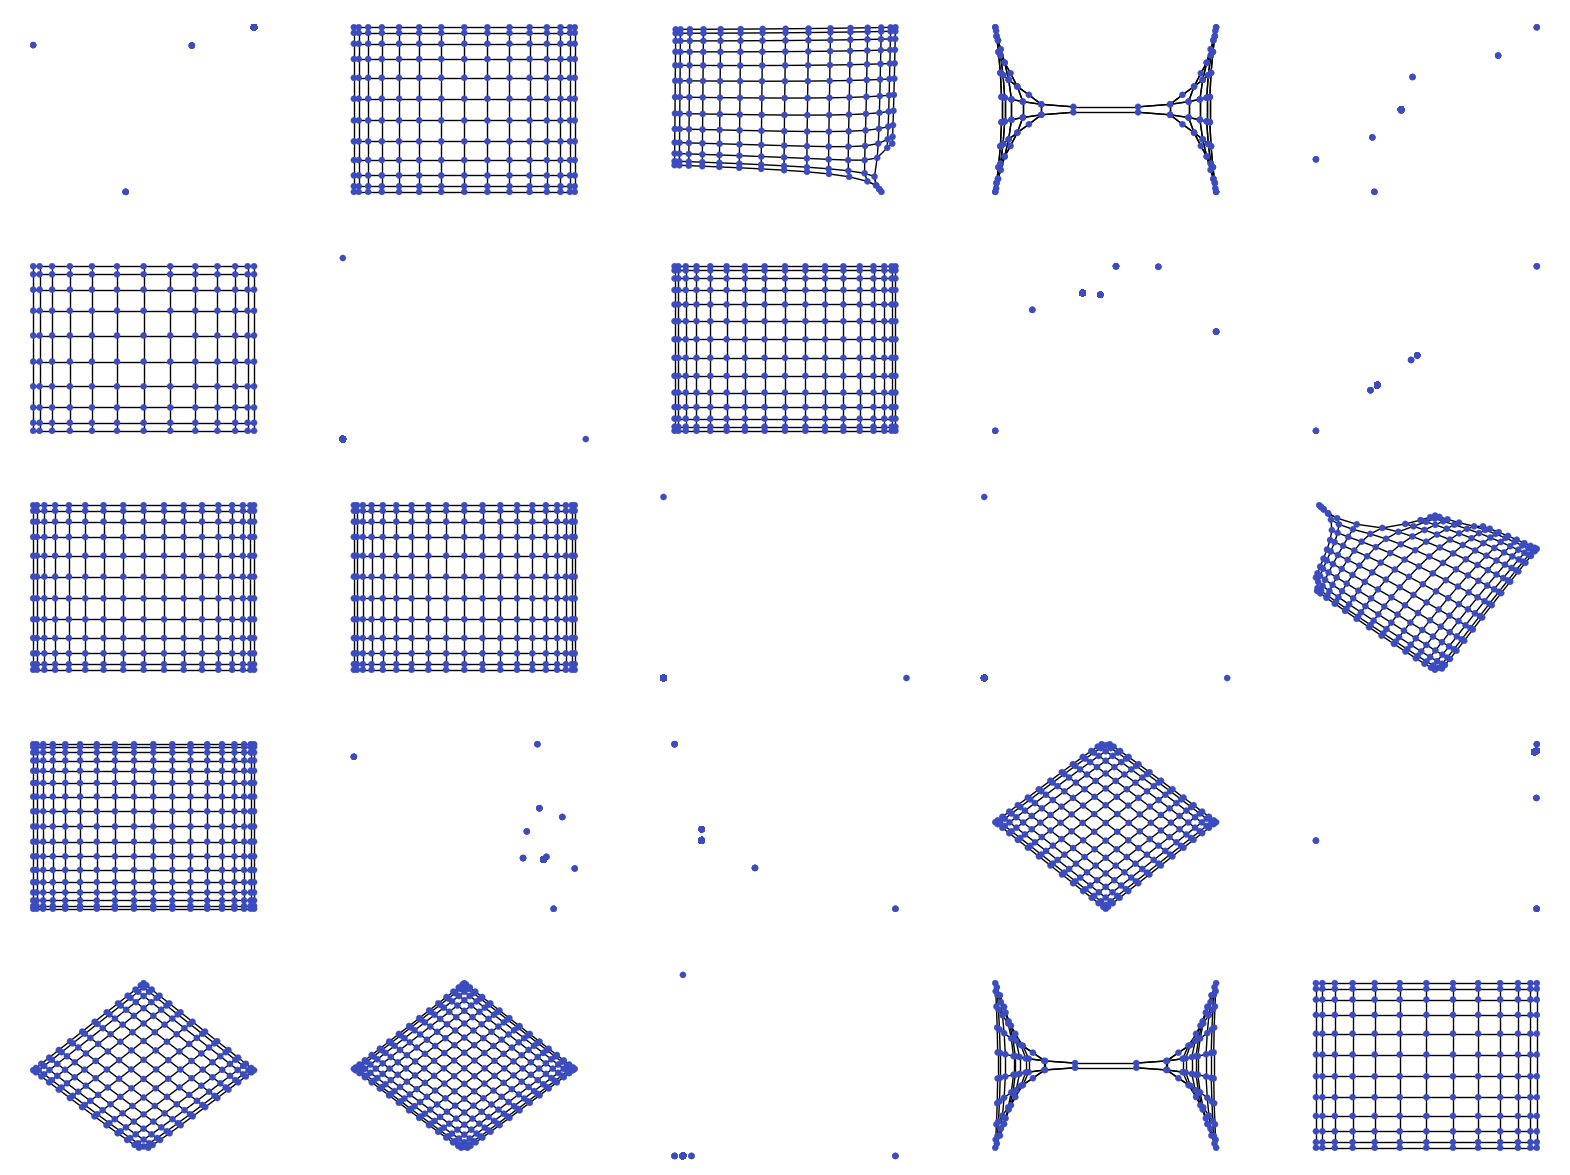

In [21]:
from pard.utils import from_batch_onehot_to_pyg_list, plot_pgy_graphs 
from torch_geometric.data import Data   
import pickle

path = 'checkpoints/local_denoising/grid.1hops.ppgnTrans-Parallel.BlockID01.ln.PreNorm=1.H256.E48.L10-lr0.0003.plateau-ires1.blocktime0.uni_noise0.T50.cosine.vlb1.ce0.1.combine=False/generated_graphs.pkl'
# path = 'checkpoints/local_denoising/grid.1hops.ppgnTrans-BatchedSeq.BlockID01.ln.PreNorm=1.H96.E16.L6-lr0.0002.plateau-ires1.blocktime0.uni_noise0.T50.cosine.vlb1.ce0.1.combine=False/generated_graphs.pkl'
with open(path, 'rb') as file:
    graph_list = pickle.load(file)


data_list = [Data(x=g[0], edge_index=g[1].nonzero().T) for g in graph_list]
plot_pgy_graphs(data_list[:25], edge_attr=None, layout='spec')

In [15]:
data_list[0]

Data(x=[170], edge_index=[2, 632])